## Identifying Credit Default with Machine Learning


##### Libraries

In [90]:
import pandas as pd
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
import missingno
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
from io import StringIO
import seaborn as sns
from ipywidgets import Image
import pydotplus

##### Data loading

In [2]:
df = pd.read_csv('credit_card_default.csv', index_col=0, na_values='')

In [3]:
!head -n 5 credit_card_default.csv

,limit_bal,sex,education,marriage,age,payment_status_sep,payment_status_aug,payment_status_jul,payment_status_jun,payment_status_may,payment_status_apr,bill_statement_sep,bill_statement_aug,bill_statement_jul,bill_statement_jun,bill_statement_may,bill_statement_apr,previous_payment_sep,previous_payment_aug,previous_payment_jul,previous_payment_jun,previous_payment_may,previous_payment_apr,default_payment_next_month
0,20000,Female,University,Married,24,Payment delayed 2 months,Payment delayed 2 months,Payed duly,Payed duly,Unknown,Unknown,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,120000,Female,University,Single,26,Payed duly,Payment delayed 2 months,Unknown,Unknown,Unknown,Payment delayed 2 months,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,Female,University,Single,34,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,Female,University,Married,37,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,46990

In [4]:
X = df.copy()
y = X.pop('default_payment_next_month')

In [5]:
df.dtypes

limit_bal                       int64
sex                            object
education                      object
marriage                       object
age                           float64
payment_status_sep             object
payment_status_aug             object
payment_status_jul             object
payment_status_jun             object
payment_status_may             object
payment_status_apr             object
bill_statement_sep              int64
bill_statement_aug              int64
bill_statement_jul              int64
bill_statement_jun              int64
bill_statement_may              int64
bill_statement_apr              int64
previous_payment_sep            int64
previous_payment_aug            int64
previous_payment_jul            int64
previous_payment_jun            int64
previous_payment_may            int64
previous_payment_apr            int64
default_payment_next_month      int64
dtype: object

In [6]:
def get_df_memory_usage(df, top_columns=5):
    print('Memory usage ----')
    memory_per_column = df.memory_usage(deep=True) / 1024 ** 2
    print(f'Top {top_columns} columns by memory (MB):')
    print(memory_per_column.sort_values(ascending=False) \
    .head(top_columns))
    print(f'Total size: {memory_per_column.sum():.4f} MB')

In [7]:
get_df_memory_usage(df)

Memory usage ----
Top 5 columns by memory (MB):
education             1.965001
payment_status_sep    1.954342
payment_status_aug    1.920288
payment_status_jul    1.916343
payment_status_jun    1.904229
dtype: float64
Total size: 20.7012 MB


##### Exploratory data analysis

In [8]:
df.describe().transpose().round(2)

,count,mean,std,min,25%,50%,75%,max
limit_bal,30000.0,167484.32,129747.66,10000.0,50000.00,140000.0,240000.00,1000000.0
age,29850.0,35.49,9.22,21.0,28.00,34.0,41.00,79.0
bill_statement_sep,30000.0,51223.33,73635.86,-165580.0,3558.75,22381.5,67091.00,964511.0
bill_statement_aug,30000.0,49179.08,71173.77,-69777.0,2984.75,21200.0,64006.25,983931.0
bill_statement_jul,30000.0,47013.15,69349.39,-157264.0,2666.25,20088.5,60164.75,1664089.0
bill_statement_jun,30000.0,43262.95,64332.86,-170000.0,2326.75,19052.0,54506.00,891586.0
bill_statement_may,30000.0,40311.40,60797.16,-81334.0,1763.00,18104.5,50190.50,927171.0
bill_statement_apr,30000.0,38871.76,59554.11,-339603.0,1256.00,17071.0,49198.25,961664.0
previous_payment_sep,30000.0,5663.58,16563.28,0.0,1000.00,2100.0,5006.00,873552.0
previous_payment_aug,30000.0,5921.16,23040.87,0.0,833.00,2009.0,5000.00,1684259.0


In [9]:
df.describe(include='object').transpose()

,count,unique,top,freq
sex,29850,2,Female,18027
education,29850,4,University,13960
marriage,29850,3,Single,15891
payment_status_sep,30000,10,Unknown,17496
payment_status_aug,30000,10,Unknown,19512
payment_status_jul,30000,10,Unknown,19849
payment_status_jun,30000,10,Unknown,20803
payment_status_may,30000,9,Unknown,21493
payment_status_apr,30000,9,Unknown,21181


/tmp/ipykernel_59304/2704254304.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[df.sex=='Male', 'age'].dropna(), hist=False, color='green', kde_kws={"shade": True}, ax=ax, label='Male')
/home/alessandro/.local/lib/python3.10/site-packages/seaborn/distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
/tmp/ipykernel_59304/2704254304.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt y

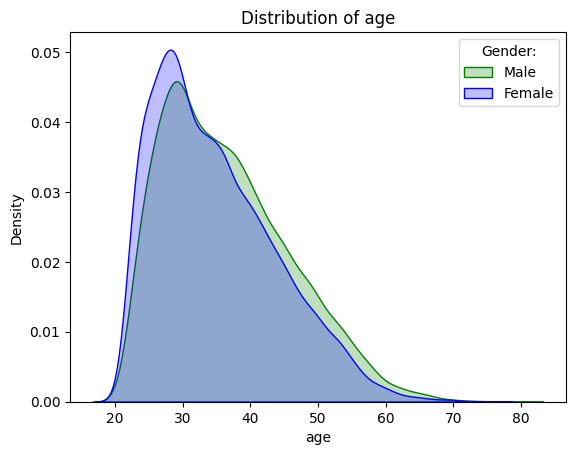

In [10]:
fig, ax = plt.subplots()
sns.distplot(df.loc[df.sex=='Male', 'age'].dropna(), hist=False, color='green', kde_kws={"shade": True}, ax=ax, label='Male')
sns.distplot(df.loc[df.sex=='Female', 'age'].dropna(), hist=False, color='blue', kde_kws={"shade": True}, ax=ax, label='Female')
ax.set_title('Distribution of age')
ax.legend(title='Gender:')

Text(0.5, 1.05, 'Pairplot of selected variables')

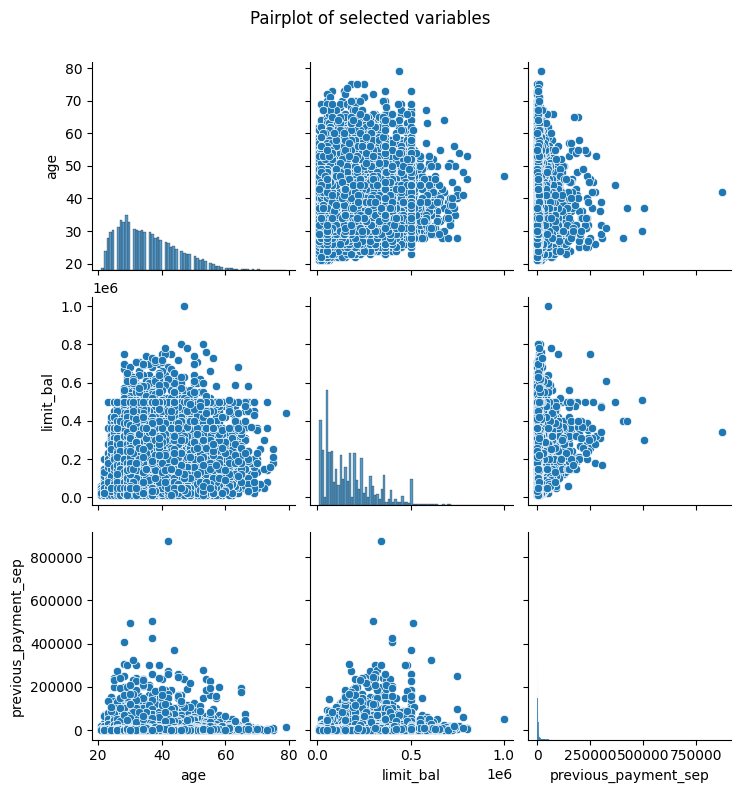

In [11]:
pair_plot = sns.pairplot(df[['age', 'limit_bal', 'previous_payment_sep']])
pair_plot.fig.suptitle('Pairplot of selected variables', y=1.05)

/tmp/ipykernel_59304/1723106565.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr_mat, dtype=np.bool)


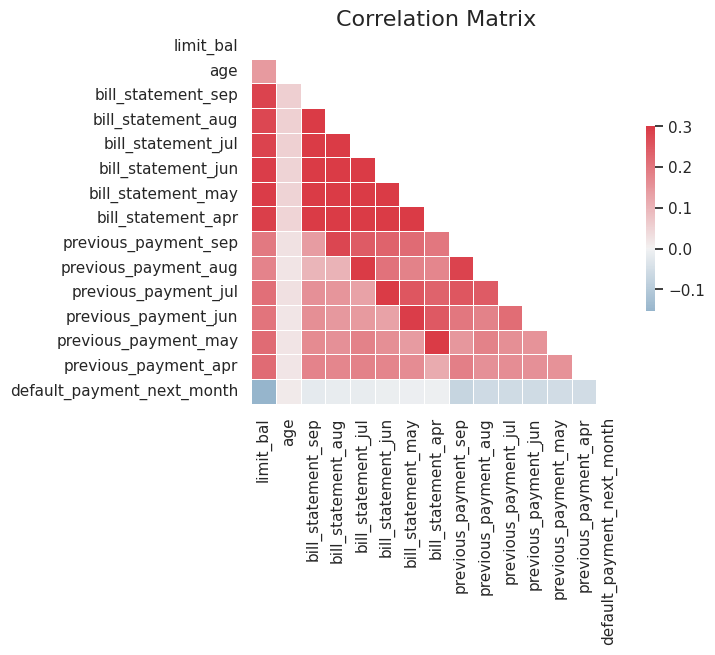

In [12]:
def plot_correlation_matrix(corr_mat):
    sns.set(style="white")
    mask = np.zeros_like(corr_mat, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots()
    cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)
    sns.heatmap(corr_mat, mask=mask, cmap=cmap, vmax=.3, center=0,
    square=True, linewidths=.5,
    cbar_kws={"shrink": .5}, ax=ax)
    ax.set_title('Correlation Matrix', fontsize=16)
    sns.set(style="darkgrid")
corr_mat = df.select_dtypes(include='number').corr()
plot_correlation_matrix(corr_mat)

In [17]:
fig = px.histogram(df, x="sex", pattern_shape="default_payment_next_month", color="sex")
fig.show()

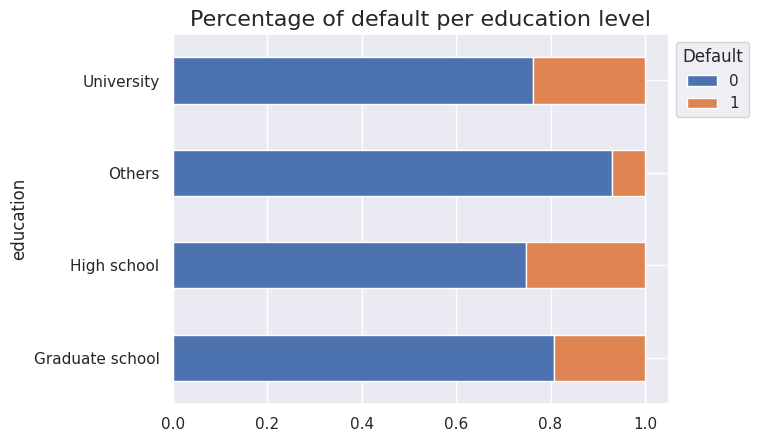

In [25]:
ax = df.groupby("education")['default_payment_next_month'] \
.value_counts(normalize=True) \
.unstack() \
.plot(kind='barh', stacked='True')
ax.set_title('Percentage of default per education level',
fontsize=16)
ax.legend(title='Default', bbox_to_anchor=(1,1))

##### Split data

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [40]:
y_train.value_counts(normalize=True)

0    0.778792
1    0.221208
Name: default_payment_next_month, dtype: float64

In [41]:
y_test.value_counts(normalize=True)

0    0.778833
1    0.221167
Name: default_payment_next_month, dtype: float64

##### Missing data

In [43]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 0 to 29999
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   limit_bal             30000 non-null  int64  
 1   sex                   29850 non-null  object 
 2   education             29850 non-null  object 
 3   marriage              29850 non-null  object 
 4   age                   29850 non-null  float64
 5   payment_status_sep    30000 non-null  object 
 6   payment_status_aug    30000 non-null  object 
 7   payment_status_jul    30000 non-null  object 
 8   payment_status_jun    30000 non-null  object 
 9   payment_status_may    30000 non-null  object 
 10  payment_status_apr    30000 non-null  object 
 11  bill_statement_sep    30000 non-null  int64  
 12  bill_statement_aug    30000 non-null  int64  
 13  bill_statement_jul    30000 non-null  int64  
 14  bill_statement_jun    30000 non-null  int64  
 15  bill_statement_may 

<AxesSubplot: >

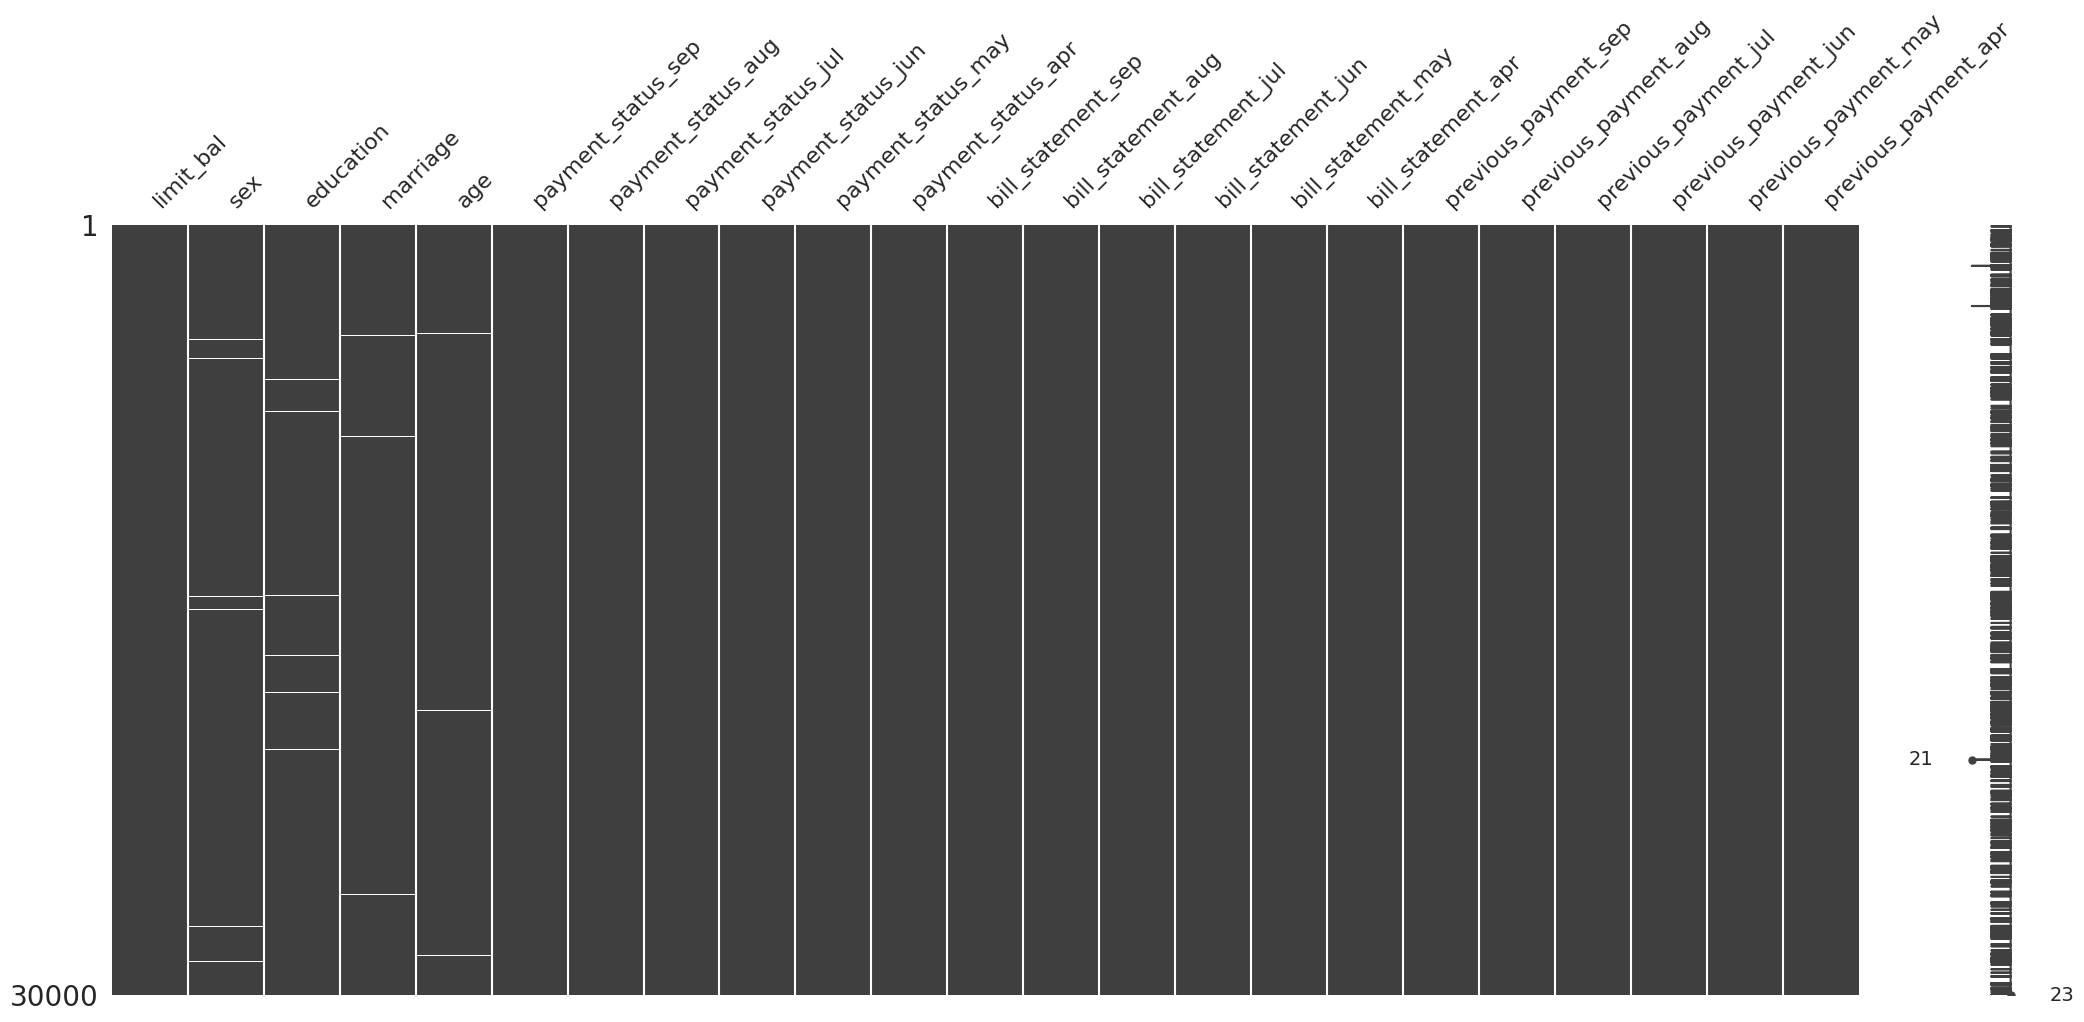

In [44]:
missingno.matrix(X)

In [45]:
NUM_FEATURES = ['age']
CAT_FEATURES = ['sex', 'education', 'marriage']

In [46]:
for col in NUM_FEATURES:
    num_imputer = SimpleImputer(strategy='median')
    num_imputer.fit(X_train[[col]])
    X_train.loc[:, col] = num_imputer.transform(X_train[[col]])
    X_test.loc[:, col] = num_imputer.transform(X_test[[col]])

In [48]:
for col in CAT_FEATURES:
    cat_imputer = SimpleImputer(strategy='most_frequent')
    cat_imputer.fit(X_train[[col]])
    X_train.loc[:, col] = cat_imputer.transform(X_train[[col]])
    X_test.loc[:, col] = cat_imputer.transform(X_test[[col]])

In [49]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24000 entries, 22788 to 27126
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   limit_bal             24000 non-null  int64  
 1   sex                   24000 non-null  object 
 2   education             24000 non-null  object 
 3   marriage              24000 non-null  object 
 4   age                   24000 non-null  float64
 5   payment_status_sep    24000 non-null  object 
 6   payment_status_aug    24000 non-null  object 
 7   payment_status_jul    24000 non-null  object 
 8   payment_status_jun    24000 non-null  object 
 9   payment_status_may    24000 non-null  object 
 10  payment_status_apr    24000 non-null  object 
 11  bill_statement_sep    24000 non-null  int64  
 12  bill_statement_aug    24000 non-null  int64  
 13  bill_statement_jul    24000 non-null  int64  
 14  bill_statement_jun    24000 non-null  int64  
 15  bill_statement_

##### Encoding

In [53]:
COL = 'education'
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()
label_enc = LabelEncoder()
label_enc.fit(X_train_copy[COL])
X_train_copy.loc[:, COL] = label_enc.transform(X_train_copy[COL])
X_test_copy.loc[:, COL] = label_enc.transform(X_test_copy[COL])

/tmp/ipykernel_59304/3953420238.py:6: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

/tmp/ipykernel_59304/3953420238.py:7: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



In [55]:
CAT_FEATURES = X_train.select_dtypes(include='object').columns.to_list()

In [56]:
one_hot_encoder = OneHotEncoder(sparse=False, handle_unknown='error', drop='first')

In [57]:
one_hot_transformer = ColumnTransformer([("one_hot", one_hot_encoder, CAT_FEATURES)])

In [58]:
one_hot_transformer.fit(X_train)

ColumnTransformer(transformers=[('one_hot',
                                 OneHotEncoder(drop='first', sparse=False),
                                 ['sex', 'education', 'marriage',
                                  'payment_status_sep', 'payment_status_aug',
                                  'payment_status_jul', 'payment_status_jun',
                                  'payment_status_may',
                                  'payment_status_apr'])])

In [60]:
col_names = one_hot_transformer.get_feature_names_out()
X_train_cat = pd.DataFrame(one_hot_transformer.transform(X_train), columns=col_names, index=X_train.index)
X_train_ohe = pd.concat([X_train, X_train_cat], axis=1).drop(CAT_FEATURES, axis=1)
X_test_cat = pd.DataFrame(one_hot_transformer.transform(X_test), columns=col_names, index=X_test.index)
X_test_ohe = pd.concat([X_test, X_test_cat], axis=1).drop(CAT_FEATURES, axis=1)

##### Decision tree classifier

In [63]:
tree_classifier = DecisionTreeClassifier()
tree_classifier.fit(X_train_ohe, y_train)
y_pred = tree_classifier.predict(X_test_ohe)

In [81]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

/home/alessandro/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



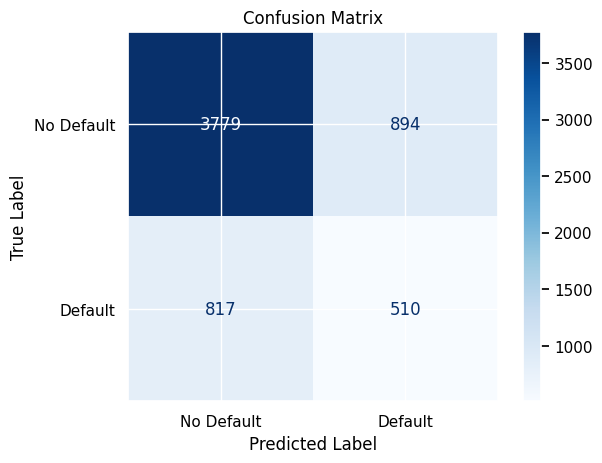

In [91]:
color='black'
LABELS = ['No Default', 'Default']
matrix = plot_confusion_matrix(tree_classifier, X_test_ohe, y_test, cmap=plt.cm.Blues, display_labels=LABELS)
matrix.ax_.set_title('Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()

In [93]:
small_tree = DecisionTreeClassifier(max_depth=3)
small_tree.fit(X_train_ohe, y_train)
tree_dot = StringIO()
export_graphviz(small_tree, feature_names=X_train_ohe.columns,
class_names=LABELS, rounded=True,
out_file=tree_dot,
proportion=False, precision=2, filled=True)
tree_graph = pydotplus.graph_from_dot_data(tree_dot.getvalue())
Image(value=tree_graph.create_png())

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x07B\x00\x00\x02A\x08\x02\x00\x00\x00T\x06\xe1\xbb\x…